# Age Cross-Prediction

In [146]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get Data

In [147]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [148]:
from common.scoring import (unimetric_scorer, 
                            custom_permutation_test_score, 
                            N_PERM, SCORING, RKF_10_10)
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [149]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (380,)


In [150]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
bin_1_X, bin_1_y = bin_1[0], bin_1[1]
bin_2_X, bin_2_y = bin_2[0], bin_2[1]
bin_3_X, bin_3_y = bin_3[0], bin_3[1]

print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

bin_1_cv = [(train, test) for train, test in RKF_10_10.split(bin_1_X)]
bin_2_cv = [(train, test) for train, test in RKF_10_10.split(bin_2_X)]
bin_3_cv = [(train, test) for train, test in RKF_10_10.split(bin_3_X)]

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


In [6]:
# From previous results
bin_alphas = [5000, 5000, 5000]

### Run cross-validation (train all, test bin)

### Run cross-validation (train bin, test bin)

### Run permutation-test (train bin, test bin)

In [142]:
%%time
bin_scores = [[], [], []]
bin_labels = ['Bin 1', 'Bin 2', 'Bin 3']

pipe = make_pipeline(StandardScaler(), Ridge(alpha=bin_alphas[0]))

n_perm = 500
results = custom_permutation_test_score(
#     pipe, bin_2, bin_1, bin_3, bin_2_cv, bin_1_cv, bin_3_cv, n_perm, unimetric_scorer)
    pipe, bin_1, bin_2, bin_3, bin_1_cv, bin_2_cv, bin_3_cv, n_perm, unimetric_scorer)

print(f'n={n_perm},', selected_target)
print('r-values: {:.4f}, {:.4f}, {:.4f}'.format(*results[0]))
print('p-values: {:.4f}, {:.4f}, {:.4f}'.format(*results[2]))
print('mean permutation r-values: {:.4f}, {:.4f}, {:.4f}'.format(*[np.mean(perms) for perms in results[1]]))
# print(results)

n=500, WISC_FSIQ
r-values: 0.2544, 0.3321, 0.1846
p-values: 0.0240, 0.0020, 0.0200
mean permutation r-values: 0.0071, -0.0034, -0.0007
CPU times: user 8h 9min 40s, sys: 9min 15s, total: 8h 18min 56s
Wall time: 49min 53s


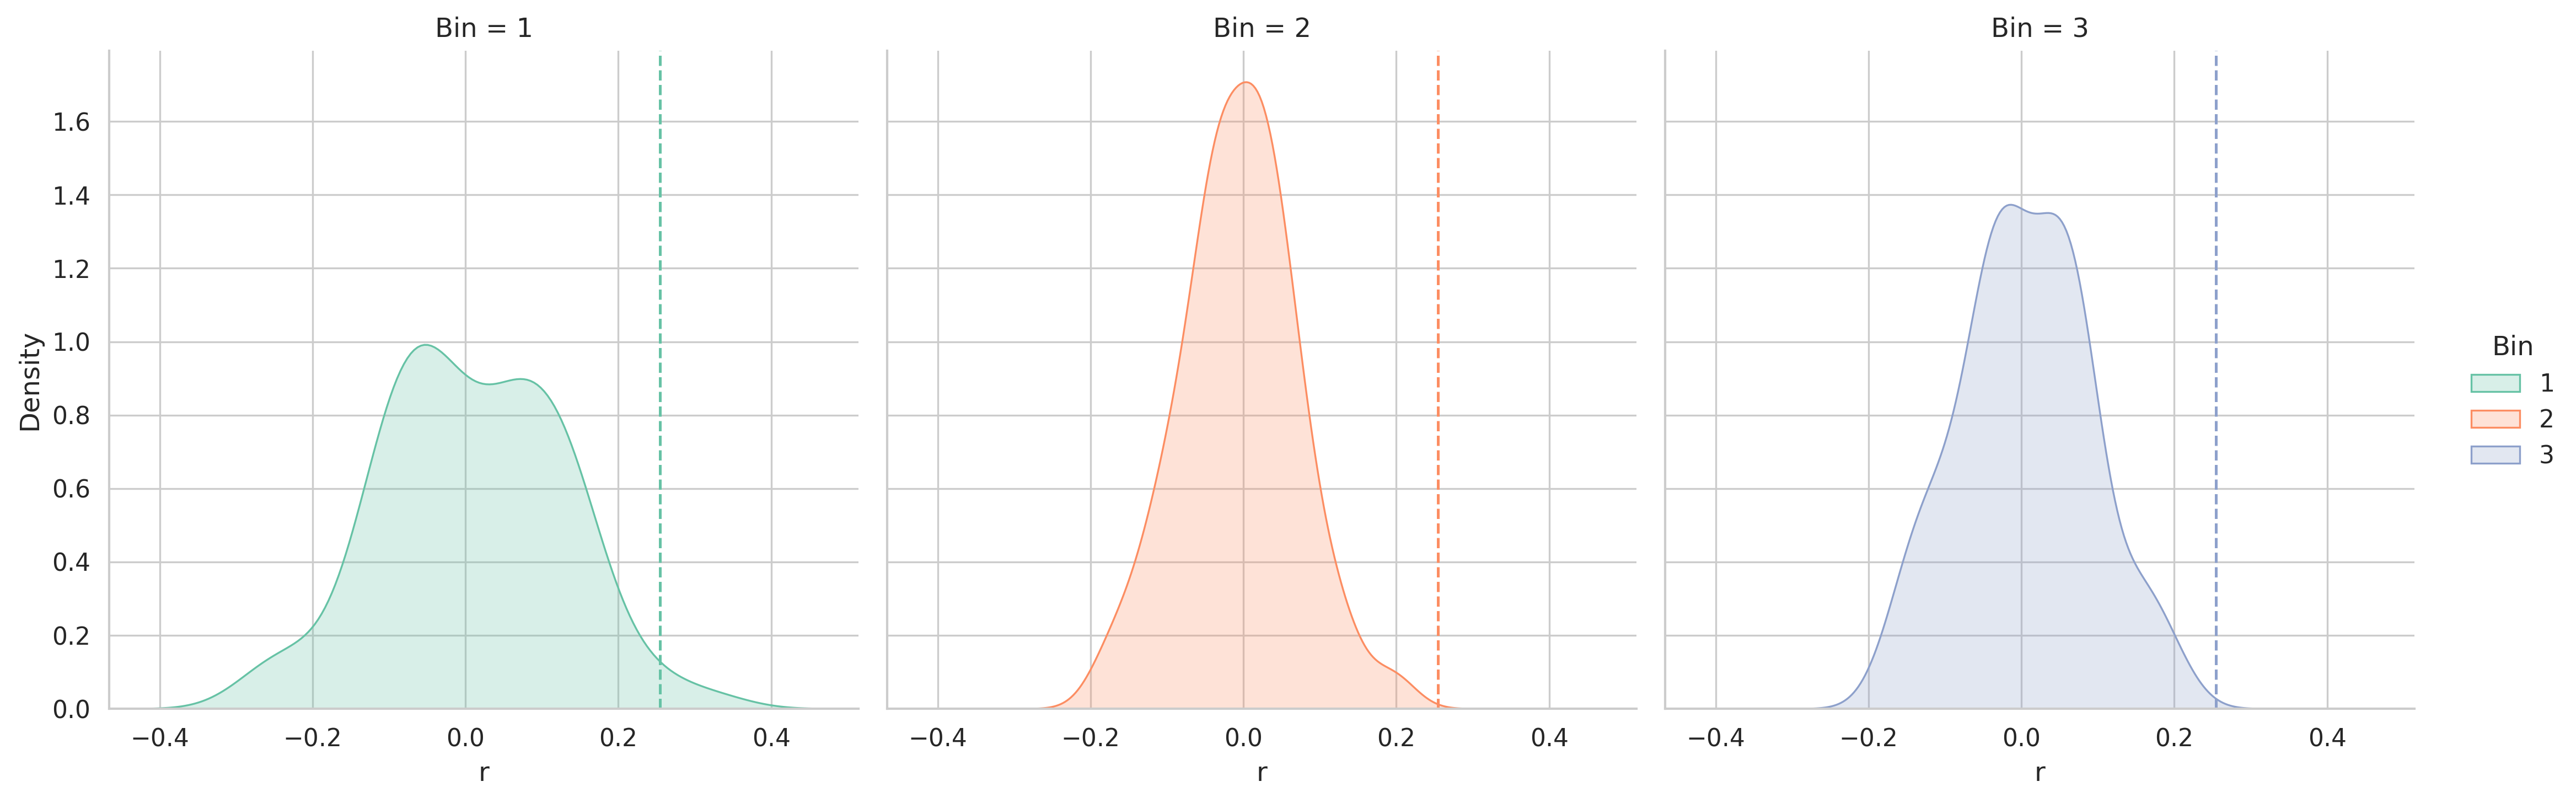

In [144]:
# g = sns.displot(data, x="r", hue="Bin", palette="Set2", element="step", col='Bin')
g = sns.displot(data, x="r", hue="Bin", palette="Set2", kind="kde", fill=True, col='Bin')

# for bin_idx, rvalue in enumerate(results[0]):
#     g.ax.axvline(rvalue, ls="--", color=sns.color_palette("Set2")[bin_idx])

for col_val, ax in g.axes_dict.items():
    ax.axvline(rvalue, ls="--", color=sns.color_palette("Set2")[col_val - 1])

In [134]:
g.axes_dict.items()

dict_items([(1, <AxesSubplot:title={'center':'Bin = 1'}, xlabel='r', ylabel='Count'>), (2, <AxesSubplot:title={'center':'Bin = 2'}, xlabel='r'>), (3, <AxesSubplot:title={'center':'Bin = 3'}, xlabel='r'>)])

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 79.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 86.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 83.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Bin', ylabel='r'>

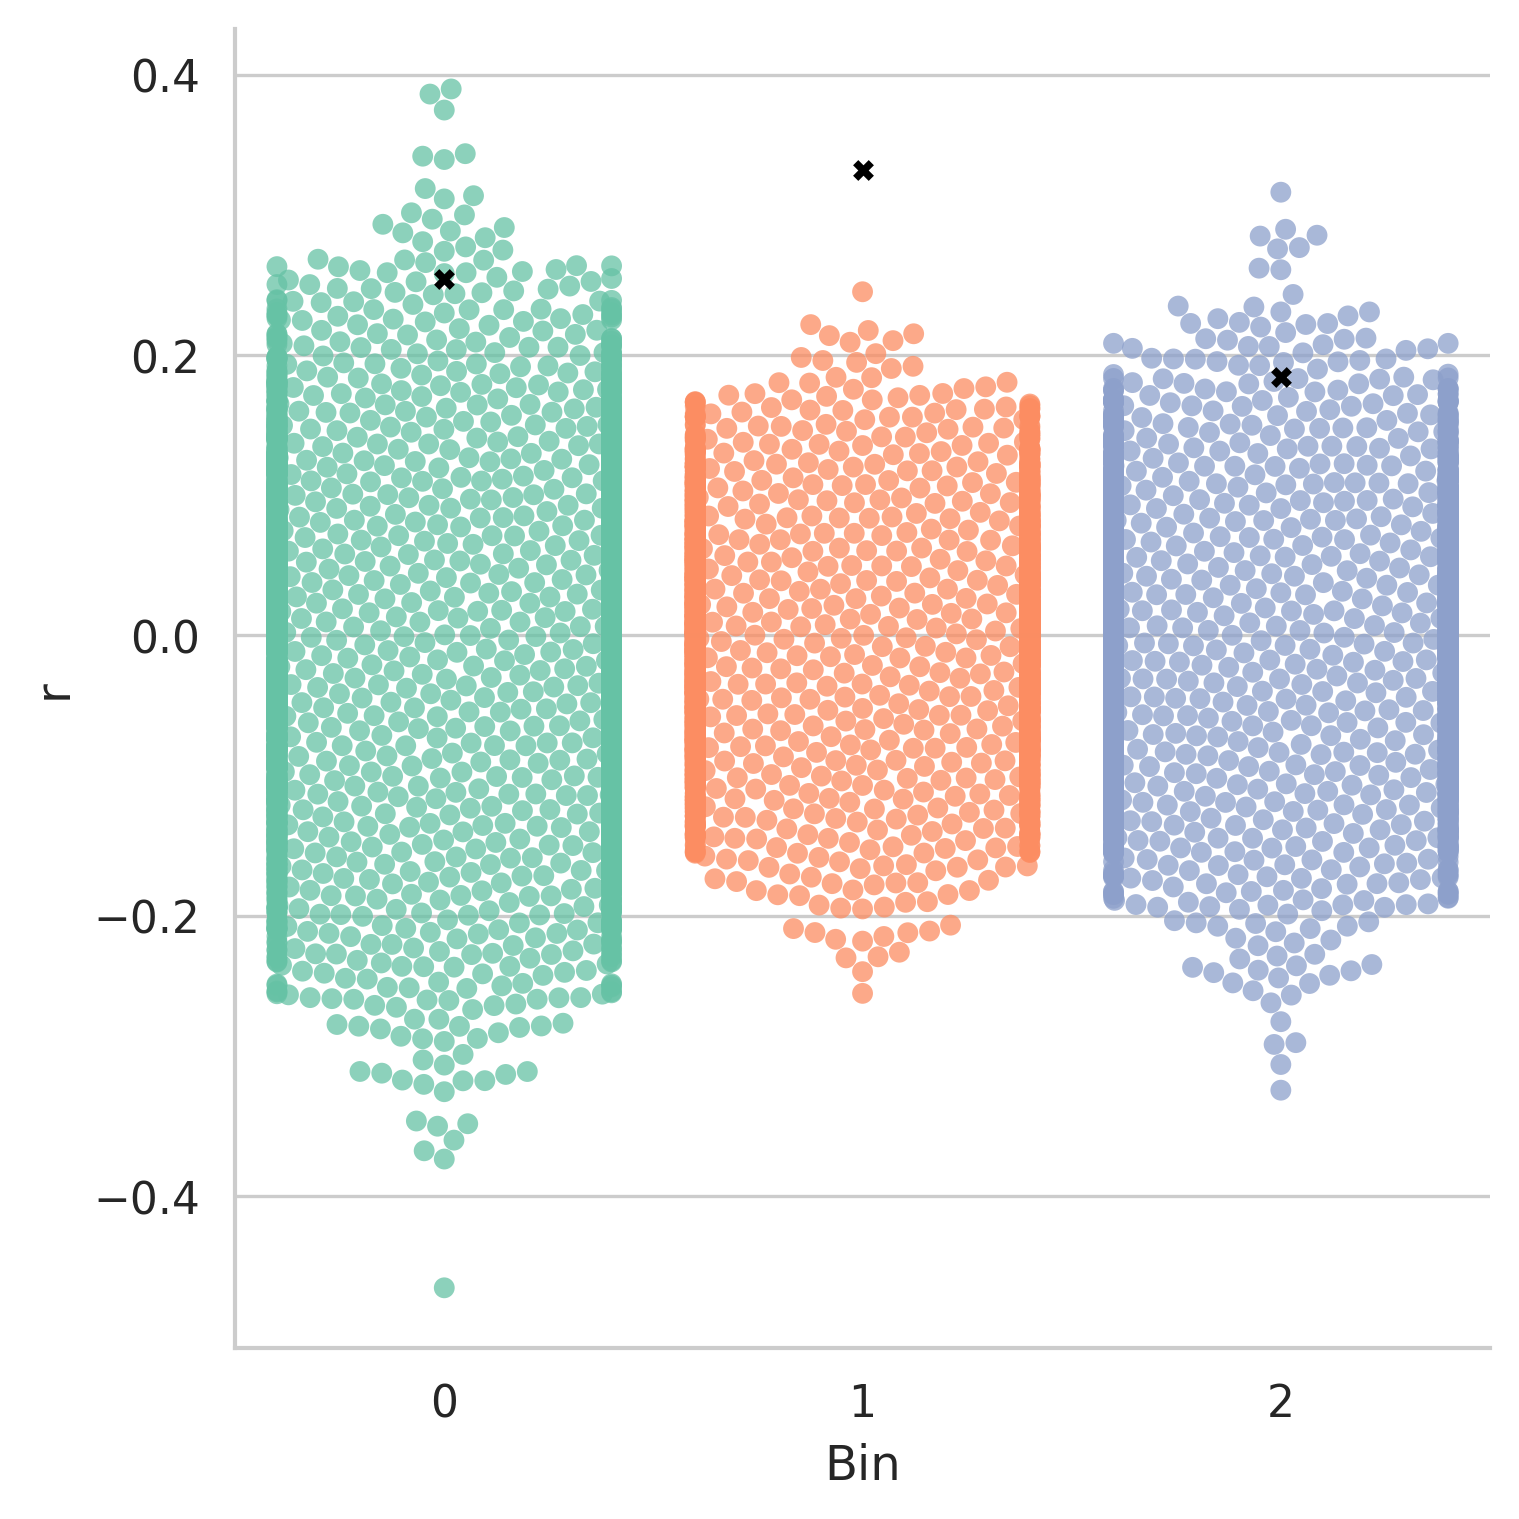

In [145]:
data = pd.melt(pd.DataFrame(results[1]).T, var_name='Bin', value_name='r')
data['Bin'] = data['Bin'] + 1

data_2 = pd.melt(pd.DataFrame(results[0]).T, var_name='Bin', value_name='r')

# display(data_2)

# Show each observation with a scatterplot
g = sns.catplot(x='Bin', y='r', data=data, kind="swarm", palette="Set2", alpha=.75)
sns.swarmplot(x='Bin', y='r', data=data_2, ax=g.ax, color='black', alpha=1, marker='X')

In [19]:
bin_1_coefs = coefs.copy()

In [26]:
bin_2_coefs = coefs.copy()

In [24]:
bin_3_coefs = coefs.copy()

### ICC

In [29]:
%%time
import pingouin as pg

group_one = pd.DataFrame(np.squeeze(np.array(bin_2_coefs), axis=2))
group_one['group'] = 'g1'

group_two = pd.DataFrame(np.squeeze(np.array(bin_3_coefs), axis=2))
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 2min 2s, sys: 1.52 s, total: 2min 3s
Wall time: 2min 13s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.111,1.249,34715,34716,0.0,"[0.1, 0.12]"
ICC2,Single random raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC3,Single fixed raters,0.111,1.249,34715,34715,0.0,"[0.1, 0.12]"
ICC1k,Average raters absolute,0.200,1.249,34715,34716,0.0,"[0.18, 0.22]"
ICC2k,Average random raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
ICC3k,Average fixed raters,0.199,1.249,34715,34715,0.0,"[0.18, 0.22]"
